In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from sklearn.metrics import mean_squared_error
from scipy import stats

In [4]:
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.al import top_model as topmodel
from DomainPrediction.al.embeddings import one_hot_encode

In [5]:
sys.path.append('../../esm')
from DomainPrediction.esm.esm3 import ESM3LM
from DomainPrediction.esm.esmc import ESMCLM
from DomainPrediction.al.confit import ESMCConFit

### Load Data

In [6]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/al_test_experiments/Tdomain'

In [7]:
file = os.path.join(data_path, 'dataset_2_tdomain.csv')
df = pd.read_csv(file)

In [8]:
df.head()

,name,seq,fitness_raw,split_id,n_mut,fitness_log
0,WT,APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALG...,1.000000,2,0,0.000000
1,ESM1,APEDSSFPRPPYAAPEGEIEQTLAGIWMELLGVERVGRHDSFFALG...,0.982485,2,44,-0.017670
2,ESM2,APSEDAYPRATYEAPEGETEQLLAGIWMDLLQVDRVGRHDSFFELG...,0.958725,0,45,-0.042151
3,ESM3,APSEDSYPRPAYVAPEGPTEQLLAGIWQELLNVSKVGRDDSFFDLG...,0.035325,2,46,-3.343159
4,ESM4,APEEASYPREPYVAPQGETEQLLASIWQELLGVERVGAGDNFFELG...,0.457921,2,43,-0.781059


In [9]:
def get_split_mask(df, omit_zero=False):
    if omit_zero:
        train_mask = (df['split_id'] == 2) & (df['fitness_raw'] != 0)
    else:
        train_mask = (df['split_id'] == 2)

    val_mask = df['split_id'] == 1
    test_mask = df['split_id'].isin([0, 1])
    # test_mask = df['split_id'] == 0

    return train_mask, val_mask, test_mask

In [10]:
def get_spearmanr_bootstrap(a, b, n=1000):
    assert type(a) == type(b) == np.ndarray
    assert len(a) == len(b)
    corr = []
    p_value = []
    np.random.seed(0)
    for _ in range(n):
        indices = np.random.choice(len(a), size=len(a), replace=True)
        res = stats.spearmanr(a[indices], b[indices])
        
        if not np.isnan(res.statistic):
            corr.append(res.statistic)
            p_value.append(res.pvalue)

    ci_lower, ci_upper = np.percentile(corr, [5, 95]) 
    # stats.t.interval(confidence=0.95, df=len(corr)-1, loc=np.mean(corr), scale=np.std(corr))
    mean_corr = np.mean(corr)

    return round(mean_corr, 2), round(ci_lower, 2), round(ci_upper, 2), corr, p_value

### Zero-shot

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)
df_train = df[train_mask]
df_val = df[val_mask]
df_test = df[test_mask]

In [ ]:
df_test['name'].to_numpy()

In [ ]:
esmc = ESMCLM(name='esmc_600m', device='gpu')

In [ ]:
wt_sequence = df.loc[df['name'] == 'WT', 'seq'].iloc[0]

In [ ]:
## wt marginals
y_pred = []
n_muts_list = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']
    score, n_muts = esmc.get_wildtype_marginal(mt_sequence, wt_sequence)
    # score, n_muts = esmc.get_masked_marginal(mt_sequence, wt_sequence)
    # score, n_muts = esmc.get_masked_marginal_var(mt_sequence, wt_sequence, mode='wt')
    # score, n_muts = esmc.get_masked_marginal_var(mt_sequence, wt_sequence, mode='mt')
    # score = esmc.pseudolikelihood(mt_sequence)

    y_pred.append(score)

    n_muts_list.append(n_muts)

y_pred = np.array(y_pred)
y = df['fitness_log'].to_numpy().astype(np.float32)

n_muts_list = np.array(n_muts_list)

In [ ]:
omit_mask = df['fitness_raw'] > -1

y_train_pred, y_train = y_pred[train_mask & omit_mask], y[train_mask & omit_mask]
y_val_pred, y_val = y_pred[val_mask & omit_mask], y[val_mask & omit_mask]
y_test_pred, y_test = y_pred[test_mask & omit_mask], y[test_mask & omit_mask]

fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.8)
ax[1].plot(y_test, y_test_pred, '.', alpha=0.8)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
omit_mask = df['fitness_raw'] > 0.01
color_mask = df['n_mut'] > 15
# color_mask = n_muts_list > 15

y_train_pred, y_train = y_pred[train_mask & omit_mask], y[train_mask & omit_mask]
y_test_pred, y_test = y_pred[test_mask & omit_mask], y[test_mask & omit_mask]

fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.8)
ax[0].plot(y[train_mask & omit_mask & color_mask], y_pred[train_mask & omit_mask & color_mask], '.', alpha=0.8, color='r')
ax[1].plot(y_test, y_test_pred, '.', alpha=0.8)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7,3), layout='constrained')
omit_mask = df['fitness_raw'] > 0.01
ax[0].hist(df['n_mut'][train_mask & omit_mask])
ax[1].hist(df['n_mut'][test_mask & omit_mask])
for i in range(2):
    ax[i].set_title('hamming dist', size=10)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7,3), layout='constrained')
omit_mask = df['fitness_raw'] > 0.01
ax[0].hist(n_muts_list[train_mask & omit_mask])
ax[1].hist(n_muts_list[test_mask & omit_mask])
for i in range(2):
    ax[i].set_title('hamming dist', size=10)

### Contrastive Fine-tuning

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from peft import LoraConfig, get_peft_model

os.environ["TOKENIZERS_PARALLELISM"] = "false"
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

In [ ]:
class ProteinFunDatasetContrast(Dataset):
    def __init__(self, df, wt):
        self.seq, self.y = df['seq'].to_numpy(), df['fitness_raw'].to_numpy()
        self.wt = np.array([wt]*self.seq.shape[0], dtype='object')
        self.n_mut = df['n_mut'].to_numpy()

        self.positions = []
        for _, row in df.iterrows():
            mt_sequence = row['seq']
            pos = []
            for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt)):
                if aa_wt != aa_mt:
                    ## mutation pos
                    pos.append(i)

            assert len(pos) == row['n_mut']

            self.positions.append(np.array(pos))

        assert len(self.positions) == self.seq.shape[0]
    
    def __len__(self):
        return self.seq.shape[0]
    
    def __getitem__(self, idx):
        return self.seq[idx], self.y[idx], self.wt[idx], self.positions[idx], self.n_mut[idx]
    
    @staticmethod
    def collate_fn(data):
        seq = np.array([x[0] for x in data], dtype='object')
        y = torch.tensor([x[1] for x in data])
        wt = np.array([x[2] for x in data], dtype='object')
        pos = [x[3] for x in data]
        n_mut = np.array([x[4] for x in data])
        return seq, y, wt, pos, n_mut

KL divergence is not correctly recorded -- I forgot why?

In [ ]:
class ESMCConFit(pl.LightningModule):
    def __init__(self, name, config) -> None:
        super().__init__()
        self.config = config

        if name == 'esmc_300m':
            self.basemodel = ESMC.from_pretrained(name)
            self.model_reg = ESMC.from_pretrained(name)
            self.emb_dim = 960
        elif name == 'esmc_600m':
            self.basemodel = ESMC.from_pretrained(name)
            self.model_reg = ESMC.from_pretrained(name)
            self.emb_dim = 1152
        else:
            raise Exception('Check ESMC name')
        
        for pm in self.model_reg.parameters():
            pm.requires_grad = False
        self.model_reg.eval()
        
        peft_config = LoraConfig(
            r=8,
            lora_alpha=8,
            lora_dropout=0.1,
            target_modules=["out_proj"],
        )
        
        self.model = get_peft_model(self.basemodel, peft_config)

        for name, pm in self.model.named_parameters():
            if 'q_ln' in name or 'k_ln' in name:
                pm.requires_grad = True

        if self.config['use_seq_head']:
            for name, pm in self.model.named_parameters():
                if 'sequence_head' in name:
                    pm.requires_grad = True
        
        if config['device'] == 'gpu':
            self.model.cuda()
            self.model_reg.cuda()

        self.lambda_reg = config['lambda']

        self.accumulate_batch_loss_train = []
        self.accumulate_batch_loss_val = []
        self.accumulate_batch_bt_loss_train = []
        self.accumulate_batch_bt_loss_val = []
        self.accumulate_batch_kl_div_train = []
        self.accumulate_batch_kl_div_val = []
        self.debug=True

    def forward(self, batch_tokens_masked, batch_tokens, batch_tokens_wt, pos):
        
        output = self.model(batch_tokens_masked)
        logits = output.sequence_logits
        log_probs = torch.log_softmax(logits, dim=-1)

        scores = torch.zeros(log_probs.shape[0])
        if self.config['device'] == 'gpu':
            scores = scores.cuda()

        for i in range(log_probs.shape[0]):
            scores[i] = torch.sum(log_probs[i, pos[i]+1, batch_tokens[i][pos[i]+1]] - log_probs[i, pos[i]+1, batch_tokens_wt[i][pos[i]+1]])
        
        return scores, logits
    
    def BT_loss(self, scores, y):
        loss = torch.tensor(0.)
        if self.config['device'] == 'gpu':
            loss = loss.cuda()

        for i in range(len(scores)):
            for j in range(i, len(scores)):
                if y[i] > y[j]:
                    if torch.abs(scores[j]-scores[i]) < 80:
                        loss += torch.log(1 + torch.exp(scores[j]-scores[i]))
                else:
                    if torch.abs(scores[i]-scores[j]) < 80:
                        loss += torch.log(1 + torch.exp(scores[i]-scores[j]))
        return loss

    def training_step(self, batch, batch_idx):
        mt_seq, y, wt_seq, pos, n_mut = batch
        batch_tokens_wt = self.model._tokenize(wt_seq)
        batch_tokens = self.model._tokenize(mt_seq)

        _positions = []

        if self.config['score'] == 'masked':
            batch_tokens_masked = batch_tokens.clone()
            for i in range(batch_tokens.shape[0]):
                _positions.append(pos[i])
                if len(pos[i]) > 0:
                    batch_tokens_masked[i, pos[i]+1] = self.model.tokenizer.mask_token_id

        elif self.config['score'] == 'masked-random':
            batch_tokens_masked = batch_tokens.clone()
            for i in range(batch_tokens.shape[0]):
                if len(pos[i]) > 0:
                    if len(pos[i]) > 40:
                        sampled_positions = np.random.choice(pos[i], 40, replace=False)
                        _positions.append(sampled_positions)
                        batch_tokens_masked[i, sampled_positions+1] = self.model.tokenizer.mask_token_id
                    else:
                        _positions.append(pos[i])
                        batch_tokens_masked[i, pos[i]+1] = self.model.tokenizer.mask_token_id
                else:
                    assert len(pos[i]) == 0
                    _positions.append(pos[i])

        elif self.config['score'] == 'wildtype':
            _positions = pos
            batch_tokens_masked = batch_tokens_wt.clone()

        else:
            raise Exception('Anata wa bakadesuka?')

        if self.config['device'] == 'gpu':
            batch_tokens_masked = batch_tokens_masked.cuda()

        assert len(_positions) == len(batch_tokens_masked)

        y_hat, logits = self(batch_tokens_masked, batch_tokens, batch_tokens_wt, _positions)

        if self.config['device'] == 'gpu':
            batch_tokens_wt = batch_tokens_wt.cuda()

        bt_loss = self.BT_loss(y_hat, y)

        output = self.model_reg(batch_tokens_wt)
        logits_reg = output.sequence_logits

        creterion_reg = torch.nn.KLDivLoss(reduction='batchmean')
        probs = torch.softmax(logits, dim=-1)
        probs_reg = torch.softmax(logits_reg, dim=-1)
        l_reg = creterion_reg(probs_reg.log().cuda(), probs)

        loss = bt_loss + self.lambda_reg*l_reg

        # print(f'contrast loss: {bt_loss.item()} | reg loss: {l_reg.item()} | loss: {loss.item()}')

        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=y.shape[0])
        self.accumulate_batch_loss_train.append(loss.item())
        self.accumulate_batch_bt_loss_train.append(bt_loss.item())
        self.accumulate_batch_kl_div_train.append(l_reg.item())
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        mt_seq, y, wt_seq, pos, n_mut = batch
        batch_tokens_wt = self.model._tokenize(wt_seq)
        batch_tokens = self.model._tokenize(mt_seq)

        # batch_tokens_masked = batch_tokens.clone()
        # for i in range(batch_tokens.shape[0]):
        #     if len(pos[i]) > 0:
        #         batch_tokens_masked[i, pos[i]+1] = self.model.tokenizer.mask_token_id
        
        # if self.config['device'] == 'gpu':
        #     batch_tokens_masked = batch_tokens_masked.cuda()

        # y_hat, logits = self(batch, batch_tokens_masked, batch_tokens, batch_tokens_wt)

        # print(y_hat)

        '''
            During validation random stuff is not needed
        '''

        if 'masked' in self.config['score']:
            batch_tokens_masked = batch_tokens.clone()
            for i in range(batch_tokens.shape[0]):
                if len(pos[i]) > 0:
                    batch_tokens_masked[i, pos[i]+1] = self.model.tokenizer.mask_token_id

        elif self.config['score'] == 'wildtype':
            batch_tokens_masked = batch_tokens_wt.clone()

        else:
            raise Exception('Anata wa bakadesuka?')
        
        if self.config['device'] == 'gpu':
            batch_tokens_masked = batch_tokens_masked.cuda()

        y_hat, logits = self(batch_tokens_masked, batch_tokens, batch_tokens_wt, pos)

        bt_loss = self.BT_loss(y_hat, y)

        if self.config['device'] == 'gpu':
            batch_tokens_wt = batch_tokens_wt.cuda()

        output = self.model_reg(batch_tokens_wt)
        logits_reg = output.sequence_logits

        creterion_reg = torch.nn.KLDivLoss(reduction='batchmean')
        probs = torch.softmax(logits, dim=-1)
        probs_reg = torch.softmax(logits_reg, dim=-1)
        l_reg = creterion_reg(probs_reg.log().cuda(), probs)

        loss = bt_loss + self.lambda_reg*l_reg

        # print(f'contrast loss: {bt_loss.item()} | reg loss: {l_reg.item()} | loss: {loss.item()}')

        self.log("val/loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=y.shape[0])
        self.accumulate_batch_loss_val.append(loss.item())
        self.accumulate_batch_bt_loss_val.append(bt_loss.item())
        self.accumulate_batch_kl_div_val.append(l_reg.item())

    def trainmodel(self, df, wt, val=None, debug=True):
        self.model.train()
        
        self.debug = debug

        train_dataset = ProteinFunDatasetContrast(df, wt)

        val_loader = None
        if val is not None:
            val_dataset = ProteinFunDatasetContrast(val, wt)
            val_loader = DataLoader(val_dataset, batch_size=self.config['batch_size'], collate_fn=ProteinFunDatasetContrast.collate_fn, shuffle=False)
        
        train_loader = DataLoader(train_dataset, batch_size=self.config['batch_size'], collate_fn=ProteinFunDatasetContrast.collate_fn, shuffle=True)
        # train_loader = DataLoader(train_dataset, batch_size=self.config['batch_size'], collate_fn=ProteinFunDatasetContrast.collate_fn, shuffle=False)

        callbacks = None
        if self.config['early_stopping']:
            callbacks = []
            earlystopping_callback = EarlyStopping(monitor="val/loss", patience=self.config['patience'], verbose=False, mode="min")
            callbacks.append(earlystopping_callback)


        trainer = pl.Trainer(max_epochs=self.config['epoch'], callbacks=callbacks,
                                accelerator="auto",
                                enable_progress_bar=False,
                                enable_model_summary=True,
                                precision="bf16-mixed",
                                accumulate_grad_batches=self.config['accumulate_batch_size']
                                )
        
        trainer.fit(model=self, train_dataloaders=train_loader, val_dataloaders=val_loader)

    def sanity_check(self, df, wt):
        '''
            Needs change to accomodate the new losses
        '''

        # print('Not usable at the moment')

        # return None

        dataset = ProteinFunDatasetContrast(df, wt)
        loader = DataLoader(dataset, batch_size=self.config['batch_size'], collate_fn=ProteinFunDatasetContrast.collate_fn, shuffle=False)

        y_pred_1 = []
        for batch in loader:
            mt_seq, y, wt_seq, pos, n_mut = batch
            batch_tokens_wt = self.model._tokenize(wt_seq)
            batch_tokens = self.model._tokenize(mt_seq)

            if 'masked' in self.config['score']:
                batch_tokens_masked = batch_tokens.clone()
                for i in range(batch_tokens.shape[0]):
                    if len(pos[i]) > 0:
                        batch_tokens_masked[i, pos[i]+1] = self.model.tokenizer.mask_token_id

            elif self.config['score'] == 'wildtype':
                batch_tokens_masked = batch_tokens_wt.clone()

            else:
                raise Exception('Anata wa bakadesuka?')
            
            if self.config['device'] == 'gpu':
                batch_tokens_masked = batch_tokens_masked.cuda()

            with torch.no_grad():
                y_hat, _ = self(batch_tokens_masked, batch_tokens, batch_tokens_wt, pos)

            y_pred_1.append(y_hat.cpu().numpy())

        y_pred_1 = np.concatenate(y_pred_1)

        y_pred_2 = []
        for i, row in df.iterrows():
            mt_sequence = row['seq']

            if 'masked' in self.config['score']:
                score, n_muts = self.get_masked_marginal(mt_sequence, wt)
            elif self.config['score'] == 'wildtype':
                score, n_muts = self.get_masked_marginal(mt_sequence, wt)
            else:
                raise Exception('Anata wa bakadesuka?')

            assert n_muts == row['n_mut']

            y_pred_2.append(score)

        y_pred_2 = np.array(y_pred_2)

        np.allclose(y_pred_1, y_pred_2, atol=1e-3)
            
    def on_train_epoch_start(self):
        self.accumulate_batch_loss_train.clear()
        self.accumulate_batch_loss_val.clear()

        self.accumulate_batch_bt_loss_train.clear()
        self.accumulate_batch_bt_loss_val.clear()

        self.accumulate_batch_kl_div_train.clear()
        self.accumulate_batch_kl_div_val.clear()
    
    def on_train_epoch_end(self):
        if self.current_epoch % self.config['print_every_n_epoch'] == 0 and self.debug:
            print(f'Epoch: {self.current_epoch}: train loss: {np.mean(self.accumulate_batch_loss_train)} bt loss: {np.mean(self.accumulate_batch_bt_loss_train)} kl div {np.mean(self.accumulate_batch_kl_div_train)} val loss: {np.mean(self.accumulate_batch_loss_val)} bt loss: {np.mean(self.accumulate_batch_bt_loss_val)} kl div {np.mean(self.accumulate_batch_kl_div_val)}')

    def on_train_end(self):
        print(f'Epoch: {self.current_epoch}: train loss: {np.mean(self.accumulate_batch_loss_train)} val loss: {np.mean(self.accumulate_batch_loss_val)}')

    def get_log_prob(self, sequence):
        esm_protein = ESMProtein(sequence=sequence)

        if self.config['device'] == 'gpu':
            self.model = self.model.cuda()

        esm_tensor = self.model.encode(esm_protein)

        with torch.no_grad():
            results = self.model.logits(
                esm_tensor, LogitsConfig(sequence=True, return_embeddings=False)
            )

        logits = results.logits.sequence

        log_prob = torch.log_softmax(logits[0, 1:-1, :33], dim=-1)

        return log_prob.to(torch.float32).cpu().numpy()
    
    def get_wildtype_marginal(self, mt_sequence, wt_sequence, wt_log_prob=None):
        if wt_log_prob is None:
            assert len(wt_sequence) == len(mt_sequence)
            wt_log_prob = self.get_log_prob(sequence=wt_sequence)

        assert wt_log_prob.shape[0] == len(wt_sequence) == len(mt_sequence)

        n_muts = 0
        score = 0
        for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt_sequence)):
            if aa_wt != aa_mt:
                ## mutation pos
                n_muts += 1

                idx_mt = self.model.tokenizer.convert_tokens_to_ids(aa_mt)
                idx_wt = self.model.tokenizer.convert_tokens_to_ids(aa_wt)
                score += wt_log_prob[i, idx_mt] - wt_log_prob[i, idx_wt]


        return score, n_muts
    
    def get_masked_marginal(self, mt_sequence, wt_sequence, mask_token = '_'):

        assert len(wt_sequence) == len(mt_sequence)

        n_muts = 0
        mask_positions = []
        for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt_sequence)):
            if aa_wt != aa_mt:
                ## mutation pos
                n_muts += 1
                mask_positions.append(i)

        assert len(mask_positions) == n_muts
        masked_query = list(wt_sequence)
        for _pos in mask_positions:
            masked_query[_pos] = mask_token
        masked_sequence = ''.join(masked_query)

        masked_log_prob = self.get_log_prob(sequence=masked_sequence)
        
        score = 0
        _idx = 0
        for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt_sequence)):
            if aa_wt != aa_mt:
                ## mutation pos

                assert mask_positions[_idx] == i
                _idx += 1

                idx_mt = self.model.tokenizer.convert_tokens_to_ids(aa_mt)
                idx_wt = self.model.tokenizer.convert_tokens_to_ids(aa_wt)
                score += masked_log_prob[i, idx_mt] - masked_log_prob[i, idx_wt]


        return score, n_muts
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.config['lr'])
    
    def print_trainable_parameters(self, model):
        trainable_params = 0
        all_param = 0
        for _, param in model.named_parameters():
            all_param += param.numel()
            if param.requires_grad:
                trainable_params += param.numel()
        print(
            f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
        )

    def get_masked_marginal_var(self, mt_sequence, wt_sequence, mask_token = '_', mode='wt'):

        assert len(wt_sequence) == len(mt_sequence)

        n_muts = 0
        score = 0
        for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt_sequence)):
            if aa_wt != aa_mt:
                ## mutation pos
                n_muts += 1

                masked_query_mt = list(mt_sequence)
                masked_query_mt[i] = mask_token
                masked_sequence_mt = ''.join(masked_query_mt)
                masked_log_prob_mt = self.get_log_prob(sequence=masked_sequence_mt)

                if mode == 'wt':
                    masked_query_wt = list(wt_sequence)
                elif mode == 'mt':
                    masked_query_wt = list(mt_sequence)
                else:
                    raise Exception('mode takes values mt and wt')

                masked_query_wt[i] = mask_token
                masked_sequence_wt = ''.join(masked_query_wt)
                masked_log_prob_wt = self.get_log_prob(sequence=masked_sequence_wt)

                idx_mt = self.model.tokenizer.convert_tokens_to_ids(aa_mt)
                idx_wt = self.model.tokenizer.convert_tokens_to_ids(aa_wt)
                score += masked_log_prob_mt[i, idx_mt] - masked_log_prob_wt[i, idx_wt]


        return score, n_muts
    
    def pseudolikelihood(self, mt_sequence, mask_token = '_'):
        score = 0
        for i, aa_mt in enumerate(zip(mt_sequence)):

            masked_query_mt = list(mt_sequence)
            masked_query_mt[i] = mask_token
            masked_sequence_mt = ''.join(masked_query_mt)
            masked_log_prob_mt = self.get_log_prob(sequence=masked_sequence_mt)

            idx_mt = self.model.tokenizer.convert_tokens_to_ids(aa_mt)
            score += masked_log_prob_mt[i, idx_mt]


        return score

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)
df_train = df[train_mask]
df_val = df[val_mask]
df_test = df[test_mask]

In [ ]:
config={'epoch': 50, 
        'batch_size': 8,
        'lambda': 0.1,
        'accumulate_batch_size': 32,
        'patience': 20,
        'early_stopping': False,
        'lr': 5e-4,
        'print_every_n_epoch': 1,
        'use_seq_head': True,
        'score': 'masked-random',
        'device': 'gpu'}

surrogate = ESMCConFit(name='esmc_600m', config=config)
surrogate.print_trainable_parameters(surrogate.model)

In [ ]:
surrogate.model

In [ ]:
for name, pm in surrogate.model.named_parameters():
    if pm.requires_grad:
        print(name)

In [ ]:
wt_sequence = df.loc[df['name'] == 'WT', 'seq'].iloc[0]

In [ ]:
surrogate.sanity_check(df_train, wt_sequence)

In [ ]:
# surrogate.config['epoch'] = 50

In [ ]:
surrogate.trainmodel(df_train, wt_sequence, df_test)

In [ ]:
## masked marginals
y_pred = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']
    score, n_muts = surrogate.get_masked_marginal(mt_sequence, wt_sequence)
    # score, n_muts = surrogate.get_wildtype_marginal(mt_sequence, wt_sequence)

    assert n_muts == row['n_mut']

    y_pred.append(score)

y_pred = np.array(y_pred)
y = df['fitness_log'].to_numpy().astype(np.float32)

In [ ]:
omit_mask = df['fitness_raw'] > -1
color_mask = df['n_mut'] > 15

y_train_pred, y_train = y_pred[train_mask & omit_mask], y[train_mask & omit_mask]
y_val_pred, y_val = y_pred[val_mask & omit_mask], y[val_mask & omit_mask]
y_test_pred, y_test = y_pred[test_mask & omit_mask], y[test_mask & omit_mask]

fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.8)
ax[0].plot(y[train_mask & omit_mask & color_mask], y_pred[train_mask & omit_mask & color_mask], '.', alpha=0.8, color='r')
ax[1].plot(y_test, y_test_pred, '.', alpha=0.8)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
omit_mask = df['fitness_raw'] > 0.01
color_mask = df['n_mut'] > 15
# color_mask = n_muts_list > 15

y_train_pred, y_train = y_pred[train_mask & omit_mask], y[train_mask & omit_mask]
y_test_pred, y_test = y_pred[test_mask & omit_mask], y[test_mask & omit_mask]

fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.8)
ax[0].plot(y[train_mask & omit_mask & color_mask], y_pred[train_mask & omit_mask & color_mask], '.', alpha=0.8, color='r')
ax[1].plot(y_test, y_test_pred, '.', alpha=0.8)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

### ESM3 LoRA

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from peft import LoraConfig, get_peft_model

os.environ["TOKENIZERS_PARALLELISM"] = "false"
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

In [12]:
class ProteinFunDatasetLora(Dataset):
    def __init__(self, df):
        self.seq, self.y = df['seq'].to_numpy(), df['fitness_log'].to_numpy().astype(np.float32)
    
    def __len__(self):
        return self.seq.shape[0]
    
    def __getitem__(self, idx):
        return self.seq[idx], self.y[idx]

In [15]:
class ESMCLoRA(pl.LightningModule):
    def __init__(self, name, config) -> None:
        super().__init__()
        self.config = config

        if name == 'esmc_300m':
            self.basemodel = ESMC.from_pretrained(name)
            self.model_reg = ESMC.from_pretrained(name)
            self.emb_dim = 960
        elif name == 'esmc_600m':
            self.basemodel = ESMC.from_pretrained(name)
            self.model_reg = ESMC.from_pretrained(name)
            self.emb_dim = 1152
        else:
            raise Exception('Check ESMC name')
        
        for pm in self.model_reg.parameters():
            pm.requires_grad = False
        self.model_reg.eval()
        
        peft_config = LoraConfig(
            r=8,
            lora_alpha=8,
            lora_dropout=0.1,
            target_modules=["out_proj", "ffn.1", "ffn.3", "layernorm_qkv.1"],
        )
        
        self.model = get_peft_model(self.basemodel, peft_config)
        # self.model = self.basemodel

        for name, pm in self.model.named_parameters():
            if 'q_ln' in name or 'k_ln' in name or 'transformer.norm.weight' in name or 'layernorm_qkv.0' in name or 'ffn.0' in name:
                pm.requires_grad = True
        
        if config['device'] == 'gpu':
            self.model.cuda()
            self.model_reg.cuda()

        self.lambda_reg = config['lambda']

        layers = []
        for i in range(1, len(config['layers'])-1):
            layers.append(nn.Linear(config['layers'][i-1], config['layers'][i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(config['layers'][-2], config['layers'][-1]))
        self.mlp = nn.Sequential(*layers)

        if config['freezePLM']:
            for name, pm in self.model.named_parameters():
                pm.requires_grad = False

        self.accumulate_batch_loss_train = []
        self.accumulate_batch_loss_val = []
        self.accumulate_batch_mse_loss_train = []
        self.accumulate_batch_mse_loss_val = []
        self.accumulate_batch_kl_div_train = []
        self.accumulate_batch_kl_div_val = []
        self.debug=True

    def forward(self, batch_tokens):
        
        output = self.model(batch_tokens)

        logits = output.sequence_logits
        embeddings = output.embeddings

        if self.config['embeddings'] == 'cls':
            cls_embedding = embeddings[:, 0, :]
        elif self.config['embeddings'] == 'mean':
            assert self.config['freezePLM']
            cls_embedding = embeddings[:,1:-1,:].mean(1)
        elif self.config['freezePLM'] == 'concat':
            assert self.config['freeze']
            cls_embedding = embeddings[:,1:-1,:].flatten()
        else:
            raise Exception('Check your config man')

        y_hat = self.mlp(cls_embedding)
        
        return y_hat, logits

    def training_step(self, batch, batch_idx):
        seq, y = batch
        batch_tokens = self.model._tokenize(seq)

        if self.config['device'] == 'gpu':
            batch_tokens = batch_tokens.cuda()

        y_hat, logits = self(batch_tokens)

        mse_loss = nn.functional.mse_loss(y_hat.flatten(), y)

        output = self.model_reg(batch_tokens)
        logits_reg = output.sequence_logits

        creterion_reg = torch.nn.KLDivLoss(reduction='batchmean')
        probs = torch.softmax(logits, dim=-1)
        probs_reg = torch.softmax(logits_reg, dim=-1)
        l_reg = creterion_reg(probs_reg.log().cuda(), probs)

        loss = mse_loss + self.lambda_reg*l_reg
        # loss = mse_loss 

        # print(f'contrast loss: {bt_loss.item()} | reg loss: {l_reg.item()} | loss: {loss.item()}')

        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=y.shape[0])
        self.accumulate_batch_loss_train.append(loss.item())
        self.accumulate_batch_mse_loss_train.append(mse_loss.item())
        self.accumulate_batch_kl_div_train.append(l_reg.item())
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        seq, y = batch
        batch_tokens = self.model._tokenize(seq)

        if self.config['device'] == 'gpu':
            batch_tokens = batch_tokens.cuda()

        y_hat, logits = self(batch_tokens)

        mse_loss = nn.functional.mse_loss(y_hat.flatten(), y)

        output = self.model_reg(batch_tokens)
        logits_reg = output.sequence_logits

        creterion_reg = torch.nn.KLDivLoss(reduction='batchmean')
        probs = torch.softmax(logits, dim=-1)
        probs_reg = torch.softmax(logits_reg, dim=-1)
        l_reg = creterion_reg(probs_reg.log().cuda(), probs)

        loss = mse_loss + self.lambda_reg*l_reg


        self.log("val/loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=y.shape[0])
        self.accumulate_batch_loss_val.append(loss.item())
        self.accumulate_batch_mse_loss_val.append(mse_loss.item())
        self.accumulate_batch_kl_div_val.append(l_reg.item())

    def trainmodel(self, df, val=None, debug=True):
        self.model.train()
        
        self.debug = debug

        train_dataset = ProteinFunDatasetLora(df)

        val_loader = None
        if val is not None:
            val_dataset = ProteinFunDatasetLora(val)
            val_loader = DataLoader(val_dataset, batch_size=self.config['batch_size'], shuffle=False)
        
        train_loader = DataLoader(train_dataset, batch_size=self.config['batch_size'], shuffle=True)
        # train_loader = DataLoader(train_dataset, batch_size=self.config['batch_size'], shuffle=False)

        callbacks = None
        if self.config['early_stopping']:
            callbacks = []
            earlystopping_callback = EarlyStopping(monitor="val/loss", patience=self.config['patience'], verbose=False, mode="min")
            callbacks.append(earlystopping_callback)


        trainer = pl.Trainer(max_epochs=self.config['epoch'], callbacks=callbacks,
                                accelerator="auto",
                                enable_progress_bar=False,
                                enable_model_summary=True,
                                precision="bf16-mixed",
                                accumulate_grad_batches=self.config['accumulate_batch_size']
                                )
        
        trainer.fit(model=self, train_dataloaders=train_loader, val_dataloaders=val_loader)
  
    def on_train_epoch_start(self):
        self.accumulate_batch_loss_train.clear()
        self.accumulate_batch_loss_val.clear()

        self.accumulate_batch_mse_loss_train.clear()
        self.accumulate_batch_mse_loss_val.clear()

        self.accumulate_batch_kl_div_train.clear()
        self.accumulate_batch_kl_div_val.clear()
    
    def on_train_epoch_end(self):
        if self.current_epoch % self.config['print_every_n_epoch'] == 0 and self.debug:
            print(f'Epoch: {self.current_epoch}: train loss: {np.mean(self.accumulate_batch_loss_train)} mse loss: {np.mean(self.accumulate_batch_mse_loss_train)} kl div {np.mean(self.accumulate_batch_kl_div_train)} val loss: {np.mean(self.accumulate_batch_loss_val)} mse loss: {np.mean(self.accumulate_batch_mse_loss_val)} kl div {np.mean(self.accumulate_batch_kl_div_val)}')

    def on_train_end(self):
        print(f'Epoch: {self.current_epoch}: train loss: {np.mean(self.accumulate_batch_loss_train)} val loss: {np.mean(self.accumulate_batch_loss_val)}')

    def get_log_prob(self, sequence):
        esm_protein = ESMProtein(sequence=sequence)

        if self.config['device'] == 'gpu':
            self.model = self.model.cuda()

        esm_tensor = self.model.encode(esm_protein)

        with torch.no_grad():
            results = self.model.logits(
                esm_tensor, LogitsConfig(sequence=True, return_embeddings=False)
            )

        logits = results.logits.sequence

        log_prob = torch.log_softmax(logits[0, 1:-1, :33], dim=-1)

        return log_prob.to(torch.float32).cpu().numpy()
    
    def get_wildtype_marginal(self, mt_sequence, wt_sequence, wt_log_prob=None):
        if wt_log_prob is None:
            assert len(wt_sequence) == len(mt_sequence)
            wt_log_prob = self.get_log_prob(sequence=wt_sequence)

        assert wt_log_prob.shape[0] == len(wt_sequence) == len(mt_sequence)

        n_muts = 0
        score = 0
        for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt_sequence)):
            if aa_wt != aa_mt:
                ## mutation pos
                n_muts += 1

                idx_mt = self.model.tokenizer.convert_tokens_to_ids(aa_mt)
                idx_wt = self.model.tokenizer.convert_tokens_to_ids(aa_wt)
                score += wt_log_prob[i, idx_mt] - wt_log_prob[i, idx_wt]


        return score, n_muts
    
    def get_masked_marginal(self, mt_sequence, wt_sequence, mask_token = '_'):

        assert len(wt_sequence) == len(mt_sequence)

        n_muts = 0
        mask_positions = []
        for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt_sequence)):
            if aa_wt != aa_mt:
                ## mutation pos
                n_muts += 1
                mask_positions.append(i)

        assert len(mask_positions) == n_muts
        masked_query = list(wt_sequence)
        for _pos in mask_positions:
            masked_query[_pos] = mask_token
        masked_sequence = ''.join(masked_query)

        masked_log_prob = self.get_log_prob(sequence=masked_sequence)
        
        score = 0
        _idx = 0
        for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt_sequence)):
            if aa_wt != aa_mt:
                ## mutation pos

                assert mask_positions[_idx] == i
                _idx += 1

                idx_mt = self.model.tokenizer.convert_tokens_to_ids(aa_mt)
                idx_wt = self.model.tokenizer.convert_tokens_to_ids(aa_wt)
                score += masked_log_prob[i, idx_mt] - masked_log_prob[i, idx_wt]


        return score, n_muts
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.config['lr'])
    
    def print_trainable_parameters(self, model):
        trainable_params = 0
        all_param = 0
        for _, param in model.named_parameters():
            all_param += param.numel()
            if param.requires_grad:
                trainable_params += param.numel()
        print(
            f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
        )

    def get_masked_marginal_var(self, mt_sequence, wt_sequence, mask_token = '_', mode='wt'):

        assert len(wt_sequence) == len(mt_sequence)

        n_muts = 0
        score = 0
        for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt_sequence)):
            if aa_wt != aa_mt:
                ## mutation pos
                n_muts += 1

                masked_query_mt = list(mt_sequence)
                masked_query_mt[i] = mask_token
                masked_sequence_mt = ''.join(masked_query_mt)
                masked_log_prob_mt = self.get_log_prob(sequence=masked_sequence_mt)

                if mode == 'wt':
                    masked_query_wt = list(wt_sequence)
                elif mode == 'mt':
                    masked_query_wt = list(mt_sequence)
                else:
                    raise Exception('mode takes values mt and wt')

                masked_query_wt[i] = mask_token
                masked_sequence_wt = ''.join(masked_query_wt)
                masked_log_prob_wt = self.get_log_prob(sequence=masked_sequence_wt)

                idx_mt = self.model.tokenizer.convert_tokens_to_ids(aa_mt)
                idx_wt = self.model.tokenizer.convert_tokens_to_ids(aa_wt)
                score += masked_log_prob_mt[i, idx_mt] - masked_log_prob_wt[i, idx_wt]


        return score, n_muts
    
    def pseudolikelihood(self, mt_sequence, mask_token = '_'):
        score = 0
        for i, aa_mt in enumerate(zip(mt_sequence)):

            masked_query_mt = list(mt_sequence)
            masked_query_mt[i] = mask_token
            masked_sequence_mt = ''.join(masked_query_mt)
            masked_log_prob_mt = self.get_log_prob(sequence=masked_sequence_mt)

            idx_mt = self.model.tokenizer.convert_tokens_to_ids(aa_mt)
            score += masked_log_prob_mt[i, idx_mt]


        return score
    
    def predict(self, sequences):
        pred = []
        for seq in tqdm(sequences):
            batch_tokens = self.model._tokenize([seq])

            if self.config['device'] == 'gpu':
                batch_tokens = batch_tokens.cuda()
                self.cuda()

                assert next(self.parameters()).is_cuda == True
            
            with torch.no_grad():

                output = self.model(batch_tokens)
                embeddings = output.embeddings

                if self.config['embeddings'] == 'cls':
                    cls_embedding = embeddings[:, 0, :]
                elif self.config['embeddings'] == 'mean':
                    assert self.config['freezePLM']
                    cls_embedding = embeddings[:,1:-1,:].mean(1)
                elif self.config['freezePLM'] == 'concat':
                    assert self.config['freeze']
                    cls_embedding = embeddings[:,1:-1,:].flatten()
                else:
                    raise Exception('Check your config man')
    
                y_hat = self.mlp(cls_embedding.to(torch.float32))

                assert y_hat.shape[0] == 1
                assert y_hat.shape[1] == 1
                pred.append(y_hat[0][0].cpu().item())

        return np.array(pred)
            

In [16]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)
df_train = df[train_mask]
df_val = df[val_mask]
df_test = df[test_mask]

In [17]:
config={'layers': [1152, 512, 1],
        'epoch': 100, 
        'batch_size': 16,
        'lambda': 0.1,
        'accumulate_batch_size': 32,
        'patience': 20,
        'early_stopping': False,
        'lr': 1e-4,
        'print_every_n_epoch': 1,
        'freezePLM': False,
        'embeddings': 'cls',
        'device': 'gpu'}

surrogate = ESMCLoRA(name='esmc_600m', config=config)
surrogate.print_trainable_parameters(surrogate.model)

trainable params: 5558400 || all params: 580345408 || trainable%: 0.96


In [18]:
for name, pm in surrogate.named_parameters():
    if pm .requires_grad:
        print(name)

basemodel.transformer.blocks.0.attn.layernorm_qkv.0.weight
basemodel.transformer.blocks.0.attn.layernorm_qkv.0.bias
basemodel.transformer.blocks.0.attn.layernorm_qkv.1.lora_A.default.weight
basemodel.transformer.blocks.0.attn.layernorm_qkv.1.lora_B.default.weight
basemodel.transformer.blocks.0.attn.out_proj.lora_A.default.weight
basemodel.transformer.blocks.0.attn.out_proj.lora_B.default.weight
basemodel.transformer.blocks.0.attn.q_ln.weight
basemodel.transformer.blocks.0.attn.k_ln.weight
basemodel.transformer.blocks.0.ffn.0.weight
basemodel.transformer.blocks.0.ffn.0.bias
basemodel.transformer.blocks.0.ffn.1.lora_A.default.weight
basemodel.transformer.blocks.0.ffn.1.lora_B.default.weight
basemodel.transformer.blocks.0.ffn.3.lora_A.default.weight
basemodel.transformer.blocks.0.ffn.3.lora_B.default.weight
basemodel.transformer.blocks.1.attn.layernorm_qkv.0.weight
basemodel.transformer.blocks.1.attn.layernorm_qkv.0.bias
basemodel.transformer.blocks.1.attn.layernorm_qkv.1.lora_A.default.w

In [19]:
surrogate

ESMCLoRA(
  (basemodel): ESMC(
    (embed): Embedding(64, 1152)
    (transformer): TransformerStack(
      (blocks): ModuleList(
        (0-35): 36 x UnifiedTransformerBlock(
          (attn): MultiHeadAttention(
            (layernorm_qkv): Sequential(
              (0): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
              (1): lora.Linear(
                (base_layer): Linear(in_features=1152, out_features=3456, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1152, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=3456, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()

In [ ]:
surrogate.config['epoch'] = 150
surrogate.config['lr'] = 1e-4

In [20]:
surrogate.trainmodel(df_train, df_test)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000 12GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-01-24 13:39:02.952203: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 13:39:02.954538: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-24 13:39:02.959271: E externa

Epoch: 0: train loss: 38.292799949645996 mse loss: 38.292799949645996 kl div 0.0 val loss: 19.21043086051941 mse loss: 19.200048446655273 kl div 0.10382414609193802
Epoch: 1: train loss: 44.4222993850708 mse loss: 44.41083526611328 kl div 0.11464129947125912 val loss: 19.173666179180145 mse loss: 19.162968039512634 kl div 0.10698577016592026
Epoch: 2: train loss: 30.975264318287373 mse loss: 30.964109655469656 kl div 0.11154678650200367 val loss: 19.13584315776825 mse loss: 19.125374019145966 kl div 0.10468899086117744
Epoch: 3: train loss: 31.115004897117615 mse loss: 31.103587716817856 kl div 0.11416732147336006 val loss: 19.100135445594788 mse loss: 19.089695811271667 kl div 0.10439766943454742
Epoch: 4: train loss: 45.874873638153076 mse loss: 45.863664627075195 kl div 0.11209895461797714 val loss: 19.06350290775299 mse loss: 19.05288165807724 kl div 0.10620872676372528
Epoch: 5: train loss: 38.02980136871338 mse loss: 38.01845455169678 kl div 0.11347308941185474 val loss: 19.02877

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch: 100: train loss: 18.487141385674477 val loss: 13.739683270454407


In [21]:
y_pred = surrogate.predict(df['seq'])
y = df['fitness_log'].to_numpy().astype(np.float32)

100%|██████████| 85/85 [00:03<00:00, 27.05it/s]


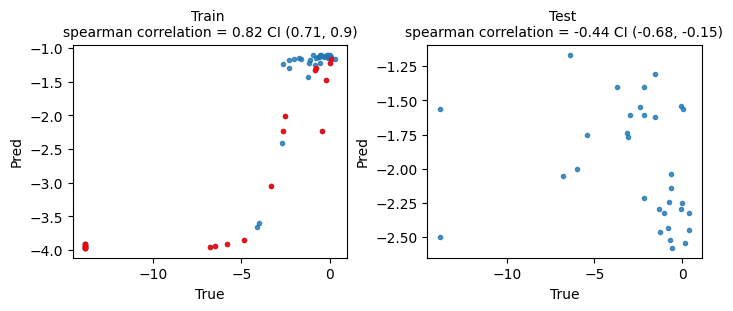

In [22]:
omit_mask = df['fitness_raw'] > -1
color_mask = df['n_mut'] > 15

y_train_pred, y_train = y_pred[train_mask & omit_mask], y[train_mask & omit_mask]
y_val_pred, y_val = y_pred[val_mask & omit_mask], y[val_mask & omit_mask]
y_test_pred, y_test = y_pred[test_mask & omit_mask], y[test_mask & omit_mask]

fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.8)
ax[0].plot(y[train_mask & omit_mask & color_mask], y_pred[train_mask & omit_mask & color_mask], '.', alpha=0.8, color='r')
ax[1].plot(y_test, y_test_pred, '.', alpha=0.8)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

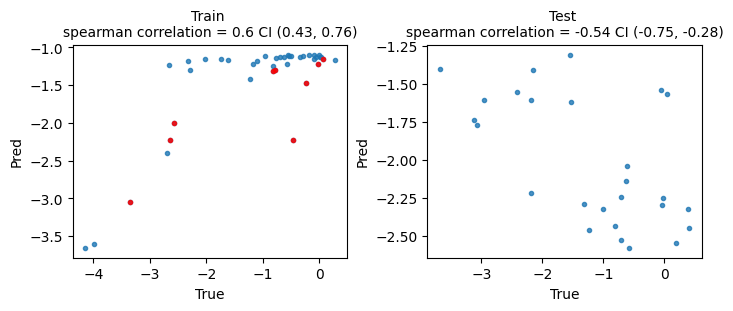

In [23]:
omit_mask = df['fitness_raw'] > 0.01
color_mask = df['n_mut'] > 15
# color_mask = n_muts_list > 15

y_train_pred, y_train = y_pred[train_mask & omit_mask], y[train_mask & omit_mask]
y_test_pred, y_test = y_pred[test_mask & omit_mask], y[test_mask & omit_mask]

fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.8)
ax[0].plot(y[train_mask & omit_mask & color_mask], y_pred[train_mask & omit_mask & color_mask], '.', alpha=0.8, color='r')
ax[1].plot(y_test, y_test_pred, '.', alpha=0.8)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()